In [2]:
''' 
AREA_output_statistics.ipynb 
By Natalie Bratset

This notebook reads the AREA output file and generates a bunch of statistics based on that output. 
Make sure to change the export_folder variable to your exports folder!

I'm planning to convert this to a .py file after writing/testing in this notebook.
'''

import os
import pandas as pd
import numpy as np
import matplotlib.patches as mplpatches
import matplotlib.pyplot as plt

# All Patients; All chr
area_results_path = os.path.expanduser("/scratch/Shares/dowell/temp/ChrisO/PSEA/AREA_fast/output/AREA_output/all_chrom_comorbidthreshold0/area_scores_20250808-192325.adjpval.csv")

# All Patients; chr21 only
# area_results_path = os.path.expanduser("/scratch/Shares/dowell/temp/ChrisO/PSEA/AREA_fast/output/AREA_output/chr21_comorbidthreshold0/area_scores_20250808-192418.adjpval.csv")

# T21 Patients; All chr
# area_results_path = os.path.expanduser("/scratch/Shares/dowell/temp/ChrisO/PSEA/AREA_fast/output/AREA_output/completeT21_all_chrom/area_scores_20250812-120736.adjpval.csv")

gene_ref_path = os.path.expanduser("/scratch/Shares/dowell/temp/ChrisO/PSEA/AREA/testdata/genes.csv")
# export_folder = os.path.expanduser("/scratch/Users/nabr7467/projects/AREA_LE/AREA_output_statistics/T21_patients_all_chr") # Change this to your export folder
export_folder = "/Users/nabr7467/projects/AREA_LE/AREA_output_statistics/all_patients_all_chr/" # Change this to your export folder

area_results = pd.read_csv(area_results_path)
gene_ref = pd.read_csv(gene_ref_path)


In [38]:
################################## USER INPUTS HERE ###########################################

# this is for setting p_val cutoffs and whatnot
# P value Columns: pval,p_value_bonf,p_value_holm,p_value_BenjaminiHochberg,p_value_BenjaminiYekutieli

##############################################################################################

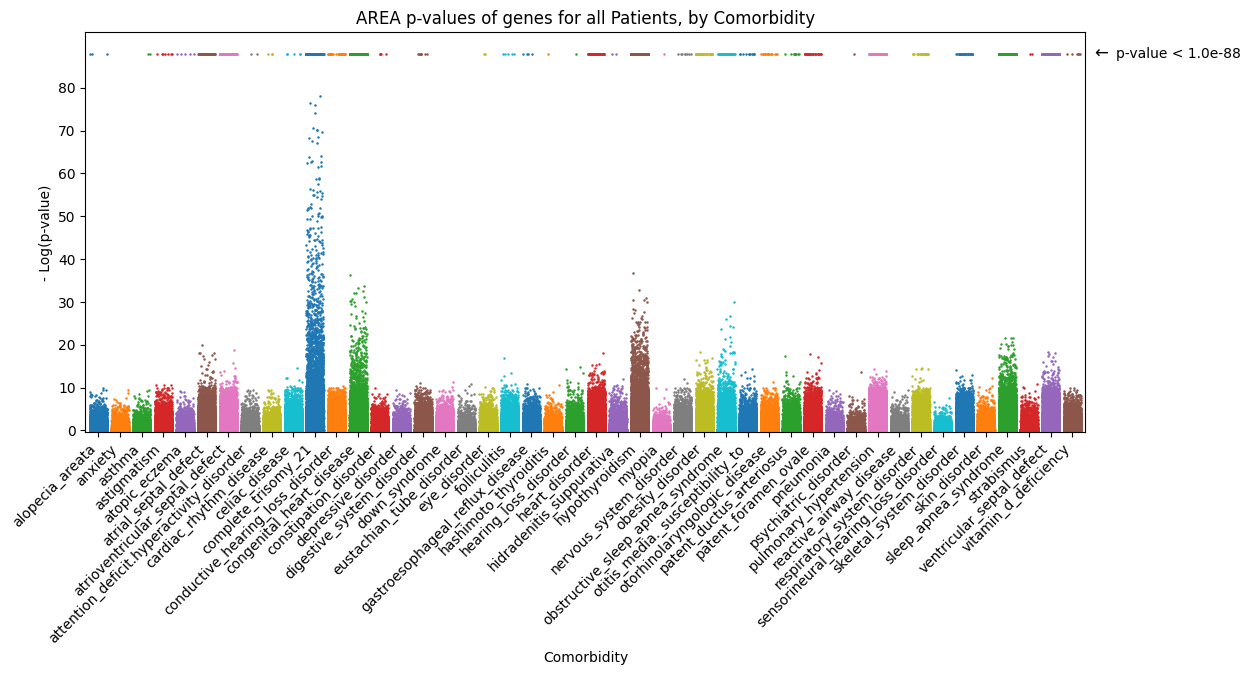

comorbid manhattan plot completed


In [34]:
def add_gene_info(df, genes_df, gene_col_AREA, gene_col_ref):
    '''Uses a gene reference dataframe to add gene info to the AREA data.'''
    df1 = df.rename(columns={gene_col_AREA: gene_col_ref})
    merged_df = pd.merge(df1, genes_df, on=gene_col_ref, how='left')
    return merged_df

def calc_linked_genes(df, group_col, pval_col, pval):
    ''' doc '''
    dictionary={}
    df_grouped = df.groupby((group_col),observed=False)
    for num, (name, group) in enumerate(df_grouped):
        filtered_df = group[group[pval_col] < pval]
        dictionary[name]=[len(filtered_df)]
    genes = pd.DataFrame(dictionary)
    
    return genes

def sum_comorbids():
    pass

def stats_export(df, genes_df, group_col, pval_col, pval):
    data_info={}
    
    gene_list=df['value'].to_list()
    gene_set=set(gene_list)
    data_info['Total Genes Ran']=len(gene_set)
    
    all = calc_linked_genes(df, group_col, pval_col, pval) #this is a dataframe with # of genes with a pval < x for each comorbid
    
    ##filter DF by chr21 ##
    chr21_genes = genes_df[genes_df['seqnames'] == '21']
    chr21_df = df[df['value'].isin(chr21_genes['gene_id'].to_list())]
    trisomy = calc_linked_genes(chr21_df, group_col, pval_col, pval) #this is a dataframe with # of genes on chr21 only with a pval < x for each comorbid
    pass

def get_num_zeros():
    pass

def minus_log_pval(df, col):
    '''Calculates -log10 of specified pvalue column and exports the given dataframe with a new 'minuslog10pvalue' column.
       This function handles pval=0 by finding the smallest non-zero p-value and treating all 0 p-values to the (smallest p-value) x (10^-10).
       Inputs: df - AREA dataframe containing p-values 
              col - Column name with the pvalues you want to convert'''
   
    df['marker'] = '.' 
    
    if 0 in area_results[col]:                                               # checks for a 0 pvalue to handle
        df.loc[df[col] == 0.0, 'marker'] = 'v'
        min_nonzero_pval = np.min(area_results[col][area_results[col] != 0]) # finds the minimum pvalue that is not 0
        adjusted_pval = min_nonzero_pval/(10**10)                            # this value is the adjusted pvalue for AREA results with a pvalue of 0. This is such that we can take the -log10(pval)
        df.loc[df[col] == 0, col] = adjusted_pval                            # change 0s to a smaller val than minimum
    
    df['minuslog10pvalue'] = -np.log10(df[col])
    
    return df


def comorbid_manhattan_plot(df, group_col, pval_col, export):
    '''Creates a manhattan plot for each comorbidity using a dataframe containing a column for groups to split up, and plots the -log10(pval) column.'''
    df[group_col] = df[group_col].str.lower()           # makes everything lowercase for read-ablility
    df = df.sort_values(group_col)
    df_grouped = df.groupby((group_col),observed=False) # groups dataframe by group_col (comorbidity)
    
    # Set Up Figure
    figureHeight=8
    figureWidth=14

    plt.figure(figsize=(figureWidth,figureHeight),facecolor='white')

    panelHeight=4
    panelWidth=10

    relativePanelWidth=panelWidth/figureWidth
    relativePanelHeight=panelHeight/figureHeight

    panel1=plt.axes([2/figureWidth,3/figureHeight,relativePanelWidth,relativePanelHeight])
    
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(df_grouped):
        x_labels.append(name)
        x_labels_pos.append(num*2)
        random_x_floats = np.random.uniform((num*2)-0.8,(num*2)+0.8,len(group[pval_col]))
        group.reset_index(inplace=True)
        panel1.scatter(random_x_floats, group[pval_col],marker='.',s=2.5)
    
    panel1.set_xticks(x_labels_pos)
    panel1.set_xticklabels(x_labels, rotation=45, ha='right')

    panel1.set_yticks(np.arange(0,np.max(df[pval_col]),10))
    
    panel1.set_xlim(-1.2,len(df_grouped)*2-0.8)
    panel1.set_ylim(-0.4,np.max(df[pval_col])+5)
    
    panel1.set_xlabel('Comorbidity')
    panel1.set_ylabel('- Log(p-value)')
    
    panel1.set_title('AREA p-values of genes for all Patients, by Comorbidity')
    
    min_nonzero_pval = np.min(area_results['p_value_bonf'][area_results['p_value_bonf'] != 0])
    adjusted_pval = min_nonzero_pval/(10**10)
    
    if 0 in area_results['p_value_bonf']:
        plt.text(len(df_grouped)*2, np.max(df[pval_col]),'\u2190',fontsize='large', va='center',ha='left')
        plt.text(len(df_grouped)*2 + 2, np.max(df[pval_col]),f'p-value < {adjusted_pval:.1e}',fontsize='medium', va='center',ha='left')
    
    
    plt.savefig(f'{export}manhattan_plot_all_by_comorbid.png',dpi=600)
    plt.show()
    plt.close()
    
    print('comorbid manhattan plot completed')

    
def chr_manhattan_plot(df, group_col, pval_col, comorbid, max_y, export):
    '''Creates a manhattan plot for each chromosome using a dataframe containing a column for chromosomes to split up, and plots the -log10(pval) column.'''
    custom_order_dict = {'1' : 0,   '2': 1,   '3': 2,   '4': 3,
                         '5' : 4,   '6': 5,   '7': 6,   '8': 7,
                         '9' : 8,  '10': 9,  '11': 10, '12': 11,
                         '13': 12, '14': 13, '15': 14, '16': 15,
                         '17': 16, '18': 17, '19': 18, '20': 19,
                         '21': 20, '22': 21,  'X': 22,  'Y': 23,
                         'MT': 24}
    
    # df[group_col] = df[group_col].str.lower()           # makes everything lowercase for read-ablility
    df_sorted = df.sort_values(by='seqnames',key=lambda x: x.map(custom_order_dict))
    df_grouped = df_sorted.groupby((group_col), sort=False, observed=False) # groups dataframe by group_col (comorbidity)
    
    # Set Up Figure
    figureHeight=6
    figureWidth=14

    plt.figure(figsize=(figureWidth,figureHeight),facecolor='white')

    panelHeight=4
    panelWidth=10

    relativePanelWidth=panelWidth/figureWidth
    relativePanelHeight=panelHeight/figureHeight

    panel1=plt.axes([2/figureWidth,1/figureHeight,relativePanelWidth,relativePanelHeight])
    
    x_labels = []
    x_labels_pos = []
    
    for num, (name, group) in enumerate(df_grouped):
        x_labels.append(name)
        x_labels_pos.append(num*2)
        random_x_floats = np.random.uniform((num*2)-0.8,(num*2)+0.8,len(group[pval_col]))
        group.reset_index(inplace=True)
        panel1.scatter(random_x_floats, group[pval_col],marker='.',s=2.5)
    # panel1.plot([-2,len(df_grouped)*2-0.8],[6,6],color='black', alpha=0.5)
    panel1.set_xticks(x_labels_pos)
    panel1.set_xticklabels(x_labels, rotation=45, ha='right')

    panel1.set_yticks(np.arange(0,max_y,10))
    
    panel1.set_xlim(-1.2,len(df_grouped)*2-0.8)
    panel1.set_ylim(-0.4,max_y+5)
    
    panel1.set_xlabel('All Chromosomes')
    panel1.set_ylabel('- Log(p-value) for each gene')
    
    panel1.set_title(f'AREA p-values of genes for Patients with {comorbid}')
    
    plt.savefig(f'{export}all_{comorbid}_by_chr.png',dpi=600)
    plt.close()
    print(f'{comorbid} plot completed')

    

## MAIN ##
combined_df = add_gene_info(area_results, gene_ref, 'value', 'gene_id')
df = minus_log_pval(combined_df,'p_value_bonf')
max_pval = np.max(df['minuslog10pvalue'])

# stats_export(area_results, gene_ref, 'binary_attribute','p_value_bonf', 0.000001)
# custom_manhattan_plot(df,'binary_attribute','minuslog10pvalue',[], export_folder) 

## One Manhattan Plot, sorted by comorbidity ##
comorbid_manhattan_plot(df,'binary_attribute','minuslog10pvalue', export_folder)

## Plots all comorbids and all chr ##
# df_grouped = df.groupby(('binary_attribute'),observed=False)
# for num, (name, group) in enumerate(df_grouped):
#     chr_manhattan_plot(group,'seqnames','minuslog10pvalue',name, max_pval, export_folder) 


#statistics
    # genes run per comorbidity
    # genes linked to comorbid (@ specific pval)
    # genes on 21 linked w/ comorbid (@ specific pval)
    